In [1]:
import glob
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

In [2]:
# algorithms = ['gemm', 'igemm', 'ipgemm', 'fft', 'fftt', 'wino']
algorithms = ['gemm', 'igemm', 'ipgemm', 'fft', 'wino']
features = ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw']

configs = pd.read_csv('./search_space/regnet_convs_unique.csv')
train_cfg_strs = []
test_cfg_strs = []
for i, row in configs.iterrows():
    cfg_str = '_'.join([str(int(row[k])) for k in features])
    if i < 4000:
        train_cfg_strs.append(cfg_str)
    else:
        test_cfg_strs.append(cfg_str)

In [3]:
def read_log(mode, algo):
    # df = pd.read_csv(sorted(glob.glob(f'./logs/{mode}/{algo}-*.csv'))[-1])
    if mode == 'energy':
        df = pd.read_csv(f'./logs/energy/{algo}-20221223.csv')
    elif mode == 'latency':
        df = pd.concat([
            pd.read_csv(f'./logs/energy/{algo}-20221226.csv'),
            pd.read_csv(f'./logs/energy/{algo}-20221229.csv'),
        ], ignore_index=True)
    df['algo'] = algorithms.index(algo)
    df['params'] = df['out_channels'] * (np.square(df['kernel_size']) * df['in_channels'] / df['groups'] + 1)
    df['flops'] = np.square(df['hw'] // df['stride'])
    return df

energy_df = pd.concat([read_log('energy', algo) for algo in algorithms], ignore_index=True)
energy_df['test'] = [
    '_'.join([str(int(row[k])) for k in features]) in test_cfg_strs
    for i, row in energy_df.iterrows()
]
latency_df = pd.concat([read_log('latency', algo) for algo in algorithms], ignore_index=True)

print(f'Energy entries: {len(energy_df)} / Latency entries: {len(latency_df)} ')
# features = features + ['params', 'flops']

energy_df['power'] = energy_df['energy'] / energy_df['latency']
energy_df

Energy entries: 18181 / Latency entries: 148238 


,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,num_warmups,num_iters,gpu_sampler,latency,energy,temperature,memory,util,algo,params,flops,test,power
0,1680,1680,3,1,10,7,7,200,8006,1,0.001079,0.060232,42.000000,2.416911,77.668605,0,2541840.0,49,False,55.845161
1,3000,3000,3,2,25,14,7,200,7357,1,0.001262,0.117318,44.886486,2.410760,51.583784,0,3243000.0,49,False,92.952447
2,208,52,1,1,1,14,7,200,39152,1,0.000221,0.010695,43.000000,2.220052,51.965318,0,10868.0,196,False,48.351768
3,792,792,3,2,11,7,7,200,25812,1,0.000361,0.017928,43.000000,2.232356,66.745946,0,514008.0,9,False,49.729312
4,448,448,3,2,4,56,7,200,4008,1,0.001906,0.108799,43.000000,2.428730,43.638158,0,452032.0,784,False,57.090366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18176,1024,1024,3,1,16,7,2,200,19862,1,0.000411,0.019818,41.000000,2.269267,39.271605,4,590848.0,49,True,48.194749
18177,288,288,3,1,6,14,2,200,16923,1,0.000308,0.014440,41.000000,2.232356,31.875000,4,124704.0,196,True,46.857536
18178,720,720,3,1,15,14,2,200,12456,1,0.000663,0.031653,42.000000,2.256963,31.368098,4,311760.0,196,True,47.744997
18179,2048,2048,3,1,16,28,2,200,1926,1,0.005562,0.302147,42.767773,2.607153,25.943128,4,2361344.0,784,True,54.323210


In [4]:
def calc_rmse(y, pred):
    return np.sqrt(np.mean(np.square(y - pred)))

def calc_err(y, pred):
    return np.abs(y - pred) / y

def calc_acc(err, r):
    return sum(err <= r) / len(err) * 100

def evaluate(model, X, y, exp2=True):
    pred = model.predict(X)
    if exp2:
        y = np.exp2(y)
        pred = np.exp2(pred)
    err = calc_err(y, pred)
    results = [calc_acc(err, 0.05), calc_acc(err, 0.1), calc_acc(err, 0.15), calc_rmse(y, pred)]
    print("5%% : %2.2f%% | 10%% : %2.2f%% | 15%% : %2.2f%% | RMSE : %1.5f" % tuple(results))
    return results

In [5]:
def calc_grid_size(df, channel_thres, hw_thres, precomp):
    channel_scale = np.ceil(df['out_channels'] / channel_thres)
    if precomp:
        hw = df['hw'] - df['kernel_size'] + 1
    else:
        hw = df['hw']
    hw_scale = np.ceil(np.square(hw / df['stride']) / hw_thres)
    return (channel_scale * hw_scale).astype(np.int32)

def add_grid_size(df):
    df['grid_size_0'] = calc_grid_size(df, 32, 32, False)
    df['grid_size_1'] = calc_grid_size(df, 128, 64, False)
    # df['grid_size_2'] = calc_grid_size(df, 256, 64, False)
    # df['grid_size_3'] = calc_grid_size(df, 32, 32, True)
    # df['grid_size_4'] = calc_grid_size(df, 128, 64, True)

# grid_size_features = ['grid_size_0', 'grid_size_1', 'grid_size_2', 'grid_size_3', 'grid_size_4']
grid_size_features = ['grid_size_0', 'grid_size_1']
add_grid_size(energy_df)
add_grid_size(latency_df)
energy_df

,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,num_warmups,num_iters,gpu_sampler,...,temperature,memory,util,algo,params,flops,test,power,grid_size_0,grid_size_1
0,1680,1680,3,1,10,7,7,200,8006,1,...,42.000000,2.416911,77.668605,0,2541840.0,49,False,55.845161,106,14
1,3000,3000,3,2,25,14,7,200,7357,1,...,44.886486,2.410760,51.583784,0,3243000.0,49,False,92.952447,188,24
2,208,52,1,1,1,14,7,200,39152,1,...,43.000000,2.220052,51.965318,0,10868.0,196,False,48.351768,14,4
3,792,792,3,2,11,7,7,200,25812,1,...,43.000000,2.232356,66.745946,0,514008.0,9,False,49.729312,25,7
4,448,448,3,2,4,56,7,200,4008,1,...,43.000000,2.428730,43.638158,0,452032.0,784,False,57.090366,350,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18176,1024,1024,3,1,16,7,2,200,19862,1,...,41.000000,2.269267,39.271605,4,590848.0,49,True,48.194749,64,8
18177,288,288,3,1,6,14,2,200,16923,1,...,41.000000,2.232356,31.875000,4,124704.0,196,True,46.857536,63,12
18178,720,720,3,1,15,14,2,200,12456,1,...,42.000000,2.256963,31.368098,4,311760.0,196,True,47.744997,161,24
18179,2048,2048,3,1,16,28,2,200,1926,1,...,42.767773,2.607153,25.943128,4,2361344.0,784,True,54.323210,1600,208


In [6]:
best_params = {'eta': 0.2, 'gamma': 0.001, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 0}

# latency_input_features = features + ['algo', 'grid_size']
latency_input_features = features + ['algo']
# latency_input_features = features

train_X, train_y = latency_df[latency_input_features], latency_df['latency']
train_y = np.log2(train_y)

xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
xgb_r.fit(train_X, train_y)
test_X, test_y = energy_df[latency_input_features], energy_df['latency']
test_y = np.log2(test_y)
print(f'Train set shape: {len(train_y)}')
acc_train = evaluate(xgb_r, train_X, train_y)
print(f'Test set shape: {len(test_y)}')
acc_test = evaluate(xgb_r, test_X, test_y)
latency_hat = xgb_r.predict(test_X)
latency_hat = np.exp2(latency_hat)
energy_df['latency_hat'] = latency_hat

# energy_df['latency_hat'] = 0
# for algo in range(len(algorithms)):
#     algo_filter = latency_df['algo'] == algo
#     algo_train_X = train_X[algo_filter]
#     algo_train_y = train_y[algo_filter]
#     cut = int(len(algo_train_y) * 0.8)
#     algo_val_X = algo_train_X.iloc[cut:, :]
#     algo_train_X = algo_train_X.iloc[:cut, :]
#     algo_val_y = algo_train_y.iloc[cut:]
#     algo_train_y = algo_train_y.iloc[:cut]
#     print(f'[{algorithms[algo]}] Train set shape: {len(algo_train_y)}')
#     xgb_r = xgb.XGBRegressor(seed=2022, n_estimators=100, **best_params)
#     xgb_r.fit(algo_train_X, algo_train_y)
#     acc_train = evaluate(xgb_r, algo_train_X, algo_train_y)
#     algo_filter = energy_df['algo'] == algo
#     algo_test_X = energy_df[algo_filter][latency_input_features]
#     algo_test_y = energy_df[algo_filter]['latency']
#     algo_test_y = np.log2(algo_test_y)
#     print(f'[{algorithms[algo]}] Val set shape: {len(algo_val_y)}')
#     acc_test = evaluate(xgb_r, algo_val_X, algo_val_y)
#     print(f'[{algorithms[algo]}] Test set shape: {len(algo_test_y)}')
#     acc_test = evaluate(xgb_r, algo_test_X, algo_test_y)
#     latency_hat = xgb_r.predict(algo_test_X)
#     latency_hat = np.exp2(latency_hat)
#     energy_df.loc[algo_filter, 'latency_hat'] = latency_hat

energy_df

Train set shape: 148238
5% : 65.82% | 10% : 89.26% | 15% : 96.12% | RMSE : 0.00177
Test set shape: 18181
5% : 51.07% | 10% : 76.60% | 15% : 87.60% | RMSE : 0.00038


,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,num_warmups,num_iters,gpu_sampler,...,memory,util,algo,params,flops,test,power,grid_size_0,grid_size_1,latency_hat
0,1680,1680,3,1,10,7,7,200,8006,1,...,2.416911,77.668605,0,2541840.0,49,False,55.845161,106,14,0.000673
1,3000,3000,3,2,25,14,7,200,7357,1,...,2.410760,51.583784,0,3243000.0,49,False,92.952447,188,24,0.001545
2,208,52,1,1,1,14,7,200,39152,1,...,2.220052,51.965318,0,10868.0,196,False,48.351768,14,4,0.000233
3,792,792,3,2,11,7,7,200,25812,1,...,2.232356,66.745946,0,514008.0,9,False,49.729312,25,7,0.000257
4,448,448,3,2,4,56,7,200,4008,1,...,2.428730,43.638158,0,452032.0,784,False,57.090366,350,52,0.002414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18176,1024,1024,3,1,16,7,2,200,19862,1,...,2.269267,39.271605,4,590848.0,49,True,48.194749,64,8,0.000416
18177,288,288,3,1,6,14,2,200,16923,1,...,2.232356,31.875000,4,124704.0,196,True,46.857536,63,12,0.000382
18178,720,720,3,1,15,14,2,200,12456,1,...,2.256963,31.368098,4,311760.0,196,True,47.744997,161,24,0.000667
18179,2048,2048,3,1,16,28,2,200,1926,1,...,2.607153,25.943128,4,2361344.0,784,True,54.323210,1600,208,0.005574


In [7]:
best_params = {'eta': 0.2, 'gamma': 0.001, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 0}

all_features = features + ['algo']
for target in ['latency', 'power', 'energy']:
    print(f'Target: {target}')
    X, y = energy_df[all_features], energy_df[target]
    y = np.log2(y)
    train_X = X[energy_df['test'] == False]
    train_y = y[energy_df['test'] == False]
    xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
    xgb_r.fit(train_X, train_y)
    xgb_r.save_model(f'./predictor/models/V100_{target}.model')


Target: latency
Target: power
Target: energy


In [8]:
best_params = {'eta': 0.2, 'gamma': 0.001, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 0}

accs = []
for all_features in [
    features + ['algo'],
    features + ['algo', 'latency'],
    # features + ['algo'] + grid_size_features,
    features + ['algo', 'latency'] + grid_size_features,
]:
    print(f'Features: {all_features}')
    X, y = energy_df[all_features], energy_df['energy']
    y = np.log2(y)
    train_X = X[energy_df['test'] == False]
    train_y = y[energy_df['test'] == False]
    print(f'Training set shape: {len(train_y)}')
    xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
    xgb_r.fit(train_X, train_y)
    acc_train = evaluate(xgb_r, train_X, train_y)
    for algo in range(len(algorithms)):
        # algo_filter = (energy_df['test'] == False) & (energy_df['algo'] == algo)
        # train_X = X[algo_filter]
        # train_y = y[algo_filter]
        # print(f'[{algorithms[algo]}] Training set shape: {len(train_y)}')
        # xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
        # xgb_r.fit(train_X, train_y)
        algo_filter = (energy_df['test'] == True) & (energy_df['algo'] == algo)
        test_X = X[algo_filter]
        if 'latency' in all_features:
            test_X = test_X.copy()
            test_X['latency'] = energy_df[algo_filter]['latency_hat']
        test_y = y[algo_filter]
        print(f'[{algorithms[algo]}] Test set shape: {len(test_y)}')
        accs.append(evaluate(xgb_r, test_X, test_y))

accs = np.array(accs).reshape((3, len(algorithms), -1))

Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo']
Training set shape: 15092
5% : 87.72% | 10% : 98.77% | 15% : 99.87% | RMSE : 0.00560
[gemm] Test set shape: 823
5% : 57.35% | 10% : 82.02% | 15% : 93.44% | RMSE : 0.01524
[igemm] Test set shape: 823
5% : 55.65% | 10% : 86.39% | 15% : 95.38% | RMSE : 0.01393
[ipgemm] Test set shape: 823
5% : 55.41% | 10% : 84.20% | 15% : 92.59% | RMSE : 0.01203
[fft] Test set shape: 413
5% : 48.43% | 10% : 77.24% | 15% : 92.98% | RMSE : 0.03290
[wino] Test set shape: 207
5% : 62.80% | 10% : 88.89% | 15% : 96.62% | RMSE : 0.00927
Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo', 'latency']
Training set shape: 15092
5% : 99.84% | 10% : 99.99% | 15% : 100.00% | RMSE : 0.00247
[gemm] Test set shape: 823
5% : 58.81% | 10% : 81.53% | 15% : 90.04% | RMSE : 0.01530
[igemm] Test set shape: 823
5% : 57.96% | 10% : 84.08% | 15% : 92.22% | RMSE : 0.01910
[ipgemm] Test set shape: 823
5%

Text(0.5, 1.0, 'Energy Predictor Accuracy on V100')

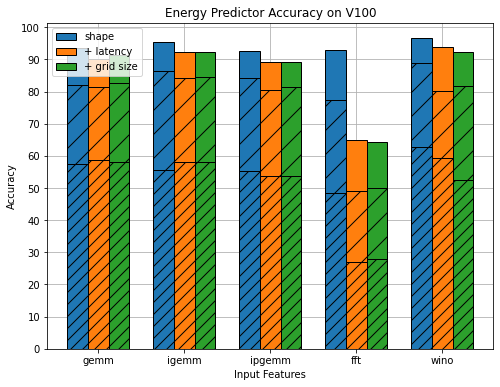

In [9]:
ind = np.arange(len(algorithms))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for i, feature_set in enumerate(['shape', '+ latency', '+ grid size']):
# for i, feature_set in enumerate(['shape', '+ grid size', '+ latency']):
    width = 0.24
    ind_shift = ind + (i - 3 // 2) * width
    ax.bar(ind_shift, accs[i, :, 2], hatch='', color=f'C{i}', edgecolor='black', width=width, label=feature_set)
    ax.bar(ind_shift, accs[i, :, 1], hatch='/', color=f'C{i}', edgecolor='black', width=width)
    ax.bar(ind_shift, accs[i, :, 0], hatch='//', color=f'C{i}', edgecolor='black', width=width)

ax.set_xticks(ind, algorithms)
ax.set_yticks(np.arange(11) * 10)
ax.grid()
ax.axis()
ax.set_axisbelow(True)
ax.set_xlabel('Input Features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Energy Predictor Accuracy on V100')

Text(0.5, 1.0, 'Energy Predictor RMSE on V100')

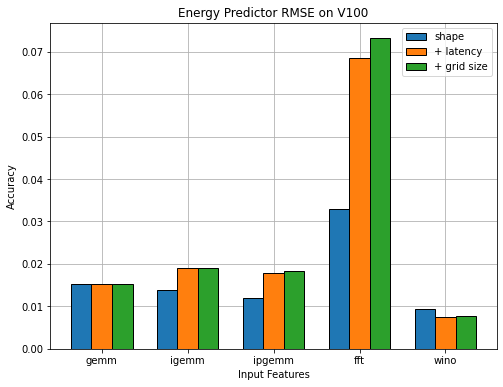

In [10]:
ind = np.arange(len(algorithms))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for i, feature_set in enumerate(['shape', '+ latency', '+ grid size']):
    width = 0.24
    ind_shift = ind + (i - 3 // 2) * width
    ax.bar(ind_shift, accs[i, :, 3], hatch='', color=f'C{i}', edgecolor='black', width=width, label=feature_set)

ax.set_xticks(ind, algorithms)
ax.grid()
ax.axis()
ax.set_axisbelow(True)
ax.set_xlabel('Input Features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Energy Predictor RMSE on V100')